# File Types

In [1]:
import os

def get_unique_filetypes(directory):
    filetypes = set()

    # Walk through the directory
    for root, _, files in os.walk(directory):
        for file in files:
            # Get the file extension and add it to the set
            _, extension = os.path.splitext(file)
            filetypes.add(extension.lower())

    return filetypes

# Example usage
directory_path = './'
unique_filetypes = get_unique_filetypes(directory_path)

print("Unique file types:")
for filetype in unique_filetypes:
    print(filetype if filetype else "No extension")

Unique file types:
No extension
.png
.meta
.txt
.docx
.py
.tif
.ipynb
.gz
.pptx
.html
.pdf


# Image Dimensions

In [2]:
import os
import numpy as np
from PIL import Image
import tifffile as tiff

def get_image_dimensions(directory):
    dimensions = set()

    # Walk through the directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        array = np.array(img)
                        dimensions.add(array.shape)
                        
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")

            elif file.lower().endswith(('.tif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with tiff.TiffFile(file_path) as img:
                        array = img.asarray()
                        dimensions.add(array.shape)
                        
                except Exception as e:
                    print(f"Could not process file {file_path}: {e}")

    return dimensions

# Example usage
directory_path = './'
unique_dimensions = get_image_dimensions(directory_path)

print("Unique image dimensions:")
for dim in unique_dimensions:
    print(dim)
    
print("\n2D image dimensions:")
for dim in unique_dimensions:
    print(tuple(filter(lambda x: x >= 30, dim)))
    

Unique image dimensions:
(14, 3, 104, 689)
(260, 940, 3)
(162, 1020)
(260, 941, 3)
(14, 3, 91, 563)
(10, 3, 107, 762)
(789, 943, 3)
(14, 3, 109, 731)
(12, 3, 110, 697)
(155, 1025)
(13, 3, 162, 1020)
(14, 3, 93, 634)
(18, 3, 89, 737)
(789, 1339, 3)
(14, 3, 76, 611)
(260, 942, 3)
(14, 3, 172, 848)
(11, 3, 113, 728)

2D image dimensions:
(104, 689)
(260, 940)
(162, 1020)
(260, 941)
(91, 563)
(107, 762)
(789, 943)
(109, 731)
(110, 697)
(155, 1025)
(162, 1020)
(93, 634)
(89, 737)
(789, 1339)
(76, 611)
(260, 942)
(172, 848)
(113, 728)


All the 2D images have height <= **172** (the exceptions of sizes (789,1339) and (789, 943) are outputs from tubulaton which aren't cropped yet)

So we can make the net take inputs of size **256 x 256** (to allow for higher resolution data later on)

# Get average/max intensities of images in folder
(i.e. Why can't we just use average image intensity?)

In [39]:
from typing import Callable

from pathlib import Path
import os

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image
import imageio.v3 as iio
import tifffile


In [45]:
# WARNING: CHANGES THE IMAGES!
# Rescale intensities

# image_dir = Path("/Users/karan/MTData/SimulatedData/Control")
# scaling_factor = 2/3  

# for filename in os.listdir(image_dir):
#     if filename.endswith(".png"):
#         # Open the image
#         img_path = os.path.join(image_dir, filename)
#         img = Image.open(img_path).convert("L")

#         # Scale the pixel values
#         img = img.point(lambda x: min(255, int(x * scaling_factor)))

#         # Save the modified image
#         img.save(img_path)

In [46]:
def load_image_to_np(image_path : Path) -> np.ndarray:
    # Get the file extension
    _, ext = os.path.splitext(image_path)
    
    # Load image based on file extension
    if ext.lower() in ['.png', '.tif']:
        image_data = iio.imread(image_path)
    elif ext.lower() == '.lsm':
        image_data = tifffile.imread(image_path)
    else:
        raise ValueError("Unsupported file format: {}".format(ext))
    
    return np.array(image_data)

Control has 118 images
Depoly has 118 images


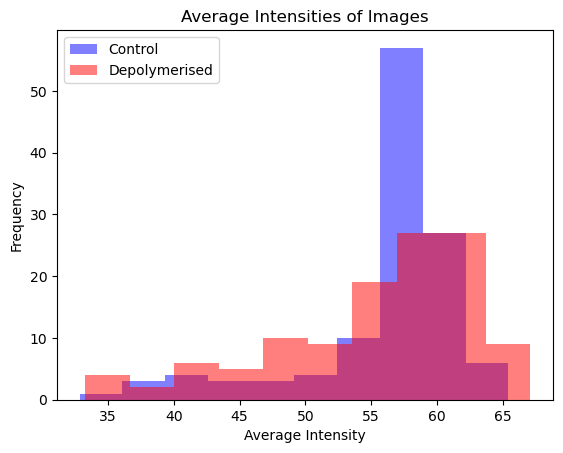

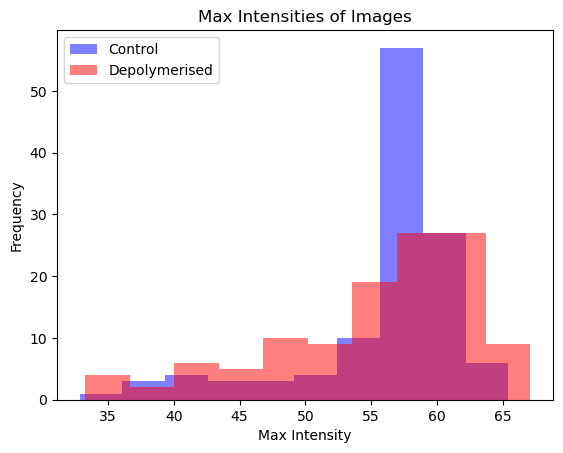

In [47]:
def get_average_intensity(image_file_path : Path) -> float:
    image_array = load_image_to_np(image_file_path)
    
    average_intensity = image_array.mean()

    return average_intensity

def get_max_intensity(image_file_path : Path) -> float:
    image_array = load_image_to_np(image_file_path)
    
    max_intensity = image_array.max()

    return max_intensity

def get_intensities_of_dir(data_dir : Path, aggregation : Callable) -> np.ndarray:
    file_names = os.listdir(data_dir)

    intensities = np.empty(len(file_names))

    for i, file_name in enumerate(file_names):
        image_file_path = data_dir / file_name
        intensities[i] = get_average_intensity(image_file_path)

    return intensities

base_dir = Path("/Users/karan/MTData/SimulatedData")
control_dir = base_dir / 'Control/'
depoly_dir = base_dir / 'Depoly'

print(f"Control has {len(os.listdir(control_dir))} images")
print(f"Depoly has {len(os.listdir(depoly_dir))} images")

average_control_intensities = get_intensities_of_dir(control_dir, get_average_intensity)
average_depoly_intensities = get_intensities_of_dir(depoly_dir, get_average_intensity)

# Plot histograms
plt.hist(average_control_intensities, alpha=0.5, color='blue', label='Control')
plt.hist(average_depoly_intensities, alpha=0.5, color='red', label='Depolymerised')

# Add labels and legend
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Average Intensities of Images')
plt.legend()

# Show plot
plt.show()

max_control_intensities = get_intensities_of_dir(control_dir, get_max_intensity)
max_depoly_intensities = get_intensities_of_dir(depoly_dir, get_max_intensity)

# Plot histograms
plt.hist(max_control_intensities, alpha=0.5, color='blue', label='Control')
plt.hist(max_depoly_intensities, alpha=0.5, color='red', label='Depolymerised')

# Add labels and legend
plt.xlabel('Max Intensity')
plt.ylabel('Frequency')
plt.title('Max Intensities of Images')
plt.legend()

# Show plot
plt.show()

In [48]:
image_file_path = Path("/Users/karan/MTData/Oryzalin/2020_07_17/plant 3 root hairs with 20  OZ.lsm")

image = load_image_to_np(image_file_path)

z_slice = 1
c_channel = 0

control_time = 0
depoly_time = 9

control_image = image[control_time, z_slice, c_channel, : , :]
depoly_image = image[depoly_time, z_slice, c_channel, : , :]

print(f"Control image has average intensity: {control_image.mean()}")
print(f"Depoly image has average intensity: {depoly_image.mean()}")

print(f"Control image has max intensity: {control_image.max()}")
print(f"Depoly image has max intensity: {depoly_image.max()}")

Control image has average intensity: 1.442429542541504
Depoly image has average intensity: 1.337021827697754
Control image has max intensity: 142
Depoly image has max intensity: 137
